### Importing packages from 1st +  2nd tutorials

In [12]:
#First Walkthrough
import json
import networkx as nx
import tweepy
#from twitter_research_api.json import bearer_token
#conda install -c conda-forge tweepy
import numpy as np
import matplotlib.pyplot as plt
import time

import csv
import pandas as pd

#Second Walkthrough
import nltk
# conda install -c conda-forge nltk
from nltk.tokenize.toktok import ToktokTokenizer
import spacy # natural language processing library
# conda install -c conda-forge spacy
from datetime import datetime 
import tweepy
import re
import string
import unicodedata
from gensim import corpora
# conda install -c conda-forge gensim

### Sentiment analysis
from textblob import TextBlob
# conda install -c conda-forge textblob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# conda install -c conda-forge vaderSentiment

### Academic Research API Info

In [23]:
#Twitter API details:
# info = {"api_key": "QArIaaUXhhzllz9cHqbEaX5Yi",
#        "api_key_secret": "g6JYuVtu93OdHBAIUoX04PjdgMeDLCn30mG55i58zXVjWSrgpi",
#        "bearer_token" : "AAAAAAAAAAAAAAAAAAAAAA0PaAEAAAAA2xD5T4i0%2F%2BVqhepeppWwya%2FwH6M%3DaUzfdTtMfLfeK0IGQpVZw1s2zKZzHHKJuzaXazJfX798fB6PWO",
#        "access_token": "1500556467916578820-2AioWqTjvBnpXSw02Kd3HMa3kPuUOj",
#        "access_token_secret": "Ls02YeSRnzrKig8lz0odHU5KazD28fHWoIEdkXDuSyDiW"}

In [4]:
info = json.loads(open('twitter_research_api.json').read())
#info = json.loads(info)

In [5]:
client = tweepy.Client(
    consumer_key        = info ["api_key"],
    consumer_secret     = info ["api_key_secret"],
    bearer_token        = info ["bearer_token"],
    access_token        = info ["access_token"],
    access_token_secret = info ["access_token_secret"],
    wait_on_rate_limit  = True
    
) 

### Scraping #LA28 tweets and putting it into a df + CSV 

In [6]:
#Takes around 1 minute to run
official_super_olympics_tweets = []
for response in tweepy.Paginator(client.search_all_tweets,
                                query = "(#superbowllvi #la28) OR (super bowl lvi la28)  OR  (super bowl NOlympicsLA) lang:en",
                                user_fields = ['username', 'public_metrics', 'description', 'location'],
                                tweet_fields = ['created_at', 'geo', 'public_metrics', 'text'],
                                expansions = 'author_id',
                                start_time = '2022-01-01T00:00:00Z',
                                end_time = '2022-04-01T00:00:00Z',
                            max_results=500):
    time.sleep(1)
    official_super_olympics_tweets.append(response)

In [17]:
#len(la28_tweets[:])
#type(la28_tweets)
for tweet in official_la28_tweets[0]:
    print(type(tweet))

#When using pagination, how do we keep type(la28_tweets) = tweepy.client.Response?
#Is there a way to run without a for loop

<class 'list'>
<class 'dict'>
<class 'list'>
<class 'dict'>


In [7]:
import json

In [147]:
help(json.dumps)

Help on function dumps in module json:

dumps(obj, *, skipkeys=False, ensure_ascii=True, check_circular=True, allow_nan=True, cls=None, indent=None, separators=None, default=None, sort_keys=False, **kw)
    Serialize ``obj`` to a JSON formatted ``str``.
    
    If ``skipkeys`` is true then ``dict`` keys that are not basic types
    (``str``, ``int``, ``float``, ``bool``, ``None``) will be skipped
    instead of raising a ``TypeError``.
    
    If ``ensure_ascii`` is false, then the return value can contain non-ASCII
    characters if they appear in strings contained in ``obj``. Otherwise, all
    such characters are escaped in JSON strings.
    
    If ``check_circular`` is false, then the circular reference check
    for container types will be skipped and a circular reference will
    result in an ``OverflowError`` (or worse).
    
    If ``allow_nan`` is false, then it will be a ``ValueError`` to
    serialize out of range ``float`` values (``nan``, ``inf``, ``-inf``) in
    stric

In [7]:
for tweet in official_super_olympics_tweets:
    print(tweet[0])
    
# [0] Tweet - List
# [1] Users - Dict
# [2] empty - List
# [3] newest ID, oldest ID, result_cuont, next_token - Dict

[<Tweet id=1511084264162578439 text='RT @jit_digital: A fines de 2024 se conocería programa olímpico de #LA28 Un tema que pone los “pelos de punta” a todas las federaciones int…'>, <Tweet id=1511068546784133120 text='RT @NOlympicsLA: Covering up sexual harassment just cost Eric Garcetti his next job.\n\nReminder: the guy he picked to run the #LA28 Olympics…'>, <Tweet id=1511063838044553219 text='RT @NOlympicsLA: Covering up sexual harassment just cost Eric Garcetti his next job.\n\nReminder: the guy he picked to run the #LA28 Olympics…'>, <Tweet id=1511063318416400384 text='RT @NOlympicsLA: Covering up sexual harassment just cost Eric Garcetti his next job.\n\nReminder: the guy he picked to run the #LA28 Olympics…'>, <Tweet id=1511046974719643660 text='#رمضان__كريم \nصحة فطوركم\n#RunInRamadhan \n#Season11\n45mn : 12km400m\n@Runkeeper @USAMastersTrack\n@IMGAmasters @WMA_Social\n#Runkeeper #USATFMasters\n#HereToCreate #StayStrong #Olympics #Paris2024 #LA28 https://t.co/QZYbG1ZNLD'>, <Twe

In [7]:
official_super_olympics_tweets[0].data[0]

<Tweet id=1498388766771212288 text='RT @NOlympicsLA: A few weeks later, tickets to the Super Bowl! What a coincidence!'>

In [19]:
#TROUBLESHOOT
# with open("#la28_tweets.json", "w") as outfile:
#     json.dump(la28_tweets, outfile, indent=4)

In [8]:
###RERUN IF DF GETS MESSED UP

result = []
user_dict = {}
# Loop through each response object:
for response in official_super_olympics_tweets:
    #Take all of the users, and put them into a dictioonoary of dictinoaries with the info we want to keep
    for user in response.includes['users']:
        user_dict[user.id] = {'username': user.username,
                              'followers': user.public_metrics ['followers_count'],
                              'tweets': user.public_metrics['tweet_count'],
                              'description': user.description,
                              'location': user.location
            }
    for tweet in response.data:
        #for each tweet, find the author's information
        author_info = user_dict[tweet.author_id]
        #put all of the information we want to keep in a single dictionary for each tweet
        result.append({'author_id': tweet.author_id,
                      'username': author_info['username'],
                      'author_followers': author_info['followers'],
                      'author_tweets': author_info['tweets'],
                      'author_description': author_info['description'],
                      'author_location': author_info['location'],
                      'text': tweet.text,
                      'created_at': tweet.created_at,
                      'retweets': tweet.public_metrics ['retweet_count'],
                      'replies': tweet.public_metrics ['reply_count'],
                      'likes': tweet.public_metrics ['like_count'],
                      'quote_count': tweet.public_metrics ['quote_count']
                      })
        
        
#change this list of dictionaries into a data frame
df = pd.DataFrame(result)

In [9]:
#Printing shape of matrix
df.shape
#should be (12186,12)

(921, 12)

In [38]:
#printing data frame
df

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count
0,1260586994821763072,dmmcdonald1,232,7798,Vietnam Vet's Widow/Mother/Proud American/Cat ...,California,@chesleydohl @DanaScu64550786 What home? No O...,2022-03-31 23:18:26+00:00,0,0,2,0
1,1341262386418728965,SugarMamaStar,96,32572,Free Palestine ...,they/them,RT @NOlympicsLA: Here’s some of #LA28 brand am...,2022-03-31 23:17:00+00:00,5,0,0,0
2,63595490,Wally_Wests,3753,857756,"Keagan, 30 ♦ creatures, cr, rambling, politics...",Australia,RT @NOlympicsLA: Here’s some of #LA28 brand am...,2022-03-31 22:55:14+00:00,5,0,0,0
3,848988333703274496,NOlympicsLA,12413,28981,Olympics always accelerate displacement & mili...,Los Angeles,Here’s some of #LA28 brand ambassador Alex Isr...,2022-03-31 22:13:40+00:00,5,1,18,0
4,900329542035918848,SylvMaev,10,1760,,None,RT @LA28: In celebration of this year’s #Title...,2022-03-31 21:05:18+00:00,10,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42569,30773016,iPublicPolicy,3367,34486,"Government Relations, Legislative Affairs & Pu...","Indianapolis, IN",@Richard_Florida @JedKolko @foxjust @emilymbad...,2020-04-02 14:16:50+00:00,0,0,0,0
42570,393591851,CMAA_HQ,3045,6146,CMAA is North America's only organization dedi...,"Vienna, VA","Though the 2020 Olympics has been put on hold,...",2020-04-01 19:15:15+00:00,0,0,0,0
42571,1091828770636320768,KatrinaG3K,379,70428,#DontLookAway,Los Angeles,RT @NOlympicsLA: It's the Chairman of the #LA2...,2020-04-01 03:36:58+00:00,2,0,0,0
42572,1067532243470438400,RobertG50380307,1188,19942,LA Veterinarian. Memoirist.,None,RT @NOlympicsLA: It's the Chairman of the #LA2...,2020-04-01 02:05:49+00:00,2,0,0,0


In [10]:
df.to_csv('super_bow_olympics_tweets.csv')

In [13]:
###Loading CSV if you want to start at this step
df = pd.read_csv('super_bowl_olympics_tweets.csv')

#df3 = pd.read_csv('super_bowl_olympics.csv')

### Adding time columns to df

In [14]:
#Adding Year Column
#pandas datetimeindex docs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html
#efficient way to extract year from string format date
df['year'] = pd.DatetimeIndex(df['created_at']).year
df.head()

,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,year
0,0,775519985921888256,colormesheesh,1851,69247,A heart that’s full up like a landfill. Dormez...,NaN,"RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 20:04:55+00:00,5,0,0,0,2022
1,1,241095220,JDWenzel,759,48984,A young autistic king chasing after his Childh...,"Los Angeles, CA","RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 19:57:34+00:00,5,0,0,0,2022
2,2,317344653,AdamOfTheSmiths,2485,42791,"Award-winning dad. Hobbies include @WP4BL, mus...","Los Angeles, CA","RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 00:40:51+00:00,5,0,0,0,2022
3,3,362875047,Aluhhhchi,528,166195,"He/Him, 1% RTs, 99% Hot Gas. 🎮🏋🏿‍♂️🏀 USFAlumni...","Los Angeles, CA","RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 00:26:34+00:00,5,0,0,0,2022
4,4,585775381,AnorveRaul,124,35888,NaN,NaN,RT @NOlympicsLA: It's incredibly clear that we...,2022-02-23 22:11:54+00:00,1,0,0,0,2022


In [15]:
#Adding Month Column
#pandas datetimeindex docs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html
df['month'] = pd.DatetimeIndex(df['created_at']).month
df.head()

,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,year,month
0,0,775519985921888256,colormesheesh,1851,69247,A heart that’s full up like a landfill. Dormez...,NaN,"RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 20:04:55+00:00,5,0,0,0,2022,2
1,1,241095220,JDWenzel,759,48984,A young autistic king chasing after his Childh...,"Los Angeles, CA","RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 19:57:34+00:00,5,0,0,0,2022,2
2,2,317344653,AdamOfTheSmiths,2485,42791,"Award-winning dad. Hobbies include @WP4BL, mus...","Los Angeles, CA","RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 00:40:51+00:00,5,0,0,0,2022,2
3,3,362875047,Aluhhhchi,528,166195,"He/Him, 1% RTs, 99% Hot Gas. 🎮🏋🏿‍♂️🏀 USFAlumni...","Los Angeles, CA","RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 00:26:34+00:00,5,0,0,0,2022,2
4,4,585775381,AnorveRaul,124,35888,NaN,NaN,RT @NOlympicsLA: It's incredibly clear that we...,2022-02-23 22:11:54+00:00,1,0,0,0,2022,2


In [16]:
#Adding Month_Year Column
#if the date format comes in datetime, we can also extract the day/month/year using the to_period function
#where 'D', 'M', 'Y' are inputs
df['month_year'] = pd.to_datetime(df['created_at']).dt.to_period('M')
df.head()

/Users/dtsloaner/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,year,month,month_year
0,0,775519985921888256,colormesheesh,1851,69247,A heart that’s full up like a landfill. Dormez...,NaN,"RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 20:04:55+00:00,5,0,0,0,2022,2,2022-02
1,1,241095220,JDWenzel,759,48984,A young autistic king chasing after his Childh...,"Los Angeles, CA","RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 19:57:34+00:00,5,0,0,0,2022,2,2022-02
2,2,317344653,AdamOfTheSmiths,2485,42791,"Award-winning dad. Hobbies include @WP4BL, mus...","Los Angeles, CA","RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 00:40:51+00:00,5,0,0,0,2022,2,2022-02
3,3,362875047,Aluhhhchi,528,166195,"He/Him, 1% RTs, 99% Hot Gas. 🎮🏋🏿‍♂️🏀 USFAlumni...","Los Angeles, CA","RT @NOlympicsLA: A few weeks later, tickets to...",2022-02-28 00:26:34+00:00,5,0,0,0,2022,2,2022-02
4,4,585775381,AnorveRaul,124,35888,NaN,NaN,RT @NOlympicsLA: It's incredibly clear that we...,2022-02-23 22:11:54+00:00,1,0,0,0,2022,2,2022-02


In [17]:
#Saving new csv with new month, year, and month_year columns
df.to_csv('month_year_super_bowl_olympics_tweets.csv')
#df.to_csv('sample_la28.csv')

In [27]:
#turning Period/Timestamp data into string data
df['month_year'].astype(str)

0        2022-03
1        2022-03
2        2022-03
3        2022-03
4        2022-03
          ...   
42569    2020-04
42570    2020-04
42571    2020-04
42572    2020-04
42573    2020-04
Name: month_year, Length: 42574, dtype: object

### Overal tweet activity per month 

In [18]:
#Counting how many tweets per month || example of time : 2020-02
tweets_per_month = {}

#Converting time stamp data into strings to iterate
#Need to assign it to a variable in order to iterate
month_year = df['month_year'].astype(str)


#for column in df['month_year']:
for time in month_year:
    #for time in column:
    if time in tweets_per_month:
        tweets_per_month[time] += 1
    else: 
        tweets_per_month[time] = 1
            
#print(tweets_per_month)

#Manually adding months with 0 tweets: 2020-01 because its easy and I'm lazy
#tweets_per_month ['2020-01'] = 0

#Sanity check 1:
print ("time is backward")
print(tweets_per_month)
            
    
#Reverse ordering the tweets_per_month dictionary so that its in chronological order
clean_time = {}
for i in reversed(tweets_per_month):
    clean_time[i] = tweets_per_month[i]

#Sanity check 2:
print ("time is now in order")
print(clean_time)

time is backward
{'2022-02': 657, '2022-01': 264}
time is now in order
{'2022-01': 264, '2022-02': 657}


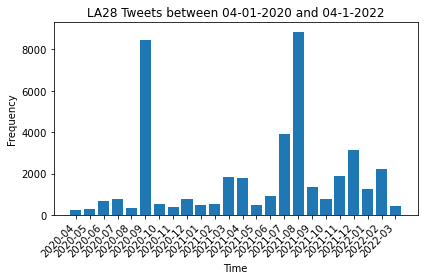

In [29]:
#plotting bar graph of num of #la28 tweets over time
#import matplotlib.pyplot as plt

data = clean_time
dates = list(data.keys())
tweet_count = list(data.values())

x = np.arange(len(dates))  # the label locations
margin = 0.09
width = (1. - 2. * margin) / 5
fig, ax = plt.subplots()

plt.bar(range(len(data)), tweet_count, tick_label=dates)

ax.set_ylabel('Frequency')
ax.set_xlabel('Time')
ax.set_title('LA28 + Super Bowl Tweets between 03-01-2020 and 04-1-2022')
ax.set_xticks(x)
ax.set_xticklabels(dates, rotation=45, ha="right")
#ax.legend()
fig.tight_layout()
plt.savefig("official_la28_super_bowl_tweets_2020-2022.png")
plt.show()

### Original Tweet Activity per month

In [58]:
#Counting Original Tweets vs RTs
RT_count = 0
OG_count = 0

text = df['text']
for tweet in text:
    if tweet[:2] == 'RT':
        RT_count += 1
    else:
        OG_count += 1
            
print("Retweet Count", RT_count)
print("Original Tweet Count", OG_count)

Retweet Count 31234
Original Tweet Count 11340


In [52]:
#Dropping RTs from month_date csv 

#NOTE: Takes a few seconds to run

#Size of df before dropping rows with RT data
print ("size of df with RTs", df.shape)

# Dropping RTs - 10301 should be dropped
dropped_RTs = 0

original_tweets_df = df

#TAKE 1:
# text = original_tweets_df['text']
# print ("ok")
# for tweet in text:
#     if tweet [:2] == 'RT':    
#         #original_tweets[original_tweets["text"].str.contains("RT ")==True]
#         original_tweets_df.drop(index, inplace=True)
        
#         dropped_RTs += 1

#TAKE 2:
text = original_tweets_df['text']
print ("ok")
for index, row in original_tweets_df.iterrows():
    if row['text'][:2] == 'RT':
    #if tweet [:2] == 'RT':    
        #original_tweets[original_tweets["text"].str.contains("RT ")==True]
        original_tweets_df.drop(index, inplace=True)
        dropped_RTs += 1
        
        
        
        
#original_tweets = df.loc[df["text"] == (tweet[:2] == 'RT') ]
print ("dropped", dropped_RTs, "rows")


#Size of df after dropping RT rows + dropped count
print ('number of RTs dropped should equal 10319:', dropped_RTs)
print ("size of df now without RTs should be 1867:", original_tweets_df.shape)

size of df with RTs (42574, 15)
ok
dropped 31234 rows
number of RTs dropped should equal 10319: 31234
size of df now without RTs should be 1867: (11340, 15)


In [32]:
#Turning original_tweets_df to a csv
original_tweets_df.to_csv('official_orginal_tweets_la28.csv')

#Shape is (1867,15)

In [33]:
#Counting how many (ORIGINAL) tweets per month again pt. 2|| example of time : 2020-02
tweets_per_month = {}

#Converting time stamp data into strings to iterate
#Need to assign it to a variable in order to iterate
month_year = original_tweets_df['month_year'].astype(str)

#for column in df['month_year']:
for time in month_year:
    if time in tweets_per_month:
        tweets_per_month[time] += 1
    else: 
        tweets_per_month[time] = 1
            
print(tweets_per_month)

#Manually adding months with 0 tweets: 2020-01 because its easy and I'm lazy
tweets_per_month ['2020-01'] = 0

#Sanity check 1:
print ("time is backward")
print(tweets_per_month)
            
    
#Reverse ordering the tweets_per_month dictionary so that its in chronological order
clean_time = {}
for i in reversed(tweets_per_month):
    clean_time[i] = tweets_per_month[i]

#Sanity check 2:
print ("time is now in order")
print(clean_time)

{'2022-03': 217, '2022-02': 880, '2022-01': 475, '2021-12': 927, '2021-11': 454, '2021-10': 250, '2021-09': 337, '2021-08': 1870, '2021-07': 1439, '2021-06': 337, '2021-05': 205, '2021-04': 369, '2021-03': 337, '2021-02': 154, '2021-01': 228, '2020-12': 225, '2020-11': 171, '2020-10': 156, '2020-09': 1613, '2020-08': 109, '2020-07': 233, '2020-06': 154, '2020-05': 110, '2020-04': 90}
time is backward
{'2022-03': 217, '2022-02': 880, '2022-01': 475, '2021-12': 927, '2021-11': 454, '2021-10': 250, '2021-09': 337, '2021-08': 1870, '2021-07': 1439, '2021-06': 337, '2021-05': 205, '2021-04': 369, '2021-03': 337, '2021-02': 154, '2021-01': 228, '2020-12': 225, '2020-11': 171, '2020-10': 156, '2020-09': 1613, '2020-08': 109, '2020-07': 233, '2020-06': 154, '2020-05': 110, '2020-04': 90, '2020-01': 0}
time is now in order
{'2020-01': 0, '2020-04': 90, '2020-05': 110, '2020-06': 154, '2020-07': 233, '2020-08': 109, '2020-09': 1613, '2020-10': 156, '2020-11': 171, '2020-12': 225, '2021-01': 228,

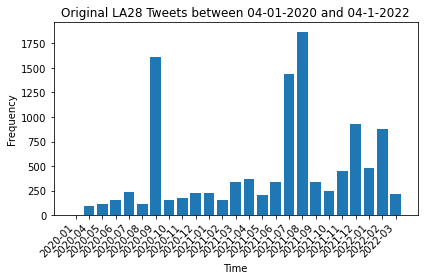

In [35]:
#plotting bar graph of num of original #la28 tweets over time
#import matplotlib.pyplot as plt

data = clean_time
dates = list(data.keys())
tweet_count = list(data.values())

x = np.arange(len(dates))  # the label locations
margin = 0.09
width = (1. - 2. * margin) / 5
fig, ax = plt.subplots()

plt.bar(range(len(data)), tweet_count, tick_label=dates)

ax.set_ylabel('Frequency')
ax.set_xlabel('Time')
ax.set_title('Original LA28 Tweets between 04-01-2020 and 04-1-2022')
ax.set_xticks(x)
ax.set_xticklabels(dates, rotation=45, ha="right")
#ax.legend()
fig.tight_layout()
plt.savefig("official_original_tweets_only_2020-2022.png")
plt.show()

### RT activity per month

In [59]:
#Dropping original tweets from month_date csv 
#NOTE: Might have to rerun cells that put data into a data frame (NOT the cells that scrape data)

#NOTE: Takes a few seconds to run

#Size of df before dropping rows with RT data
print ("size of df with RTs", df.shape)

# Dropping Original Tweets - 1867 should be dropped
dropped_og_tweets = 0

retweets_df = df

#TAKE 1:
# text = original_tweets_df['text']
# print ("ok")
# for tweet in text:
#     if tweet [:2] == 'RT':    
#         #original_tweets[original_tweets["text"].str.contains("RT ")==True]
#         original_tweets_df.drop(index, inplace=True)
        
#         dropped_RTs += 1

#TAKE 2:
text = retweets_df['text']
print ("ok")
for index, row in retweets_df.iterrows():
    if row['text'][:2] != 'RT':
    #if tweet [:2] == 'RT':    
        #original_tweets[original_tweets["text"].str.contains("RT ")==True]
        retweets_df.drop(index, inplace=True)
        dropped_og_tweets += 1
        
        
        
        
#original_tweets = df.loc[df["text"] == (tweet[:2] == 'RT') ]
print ("dropped", dropped_og_tweets, "rows")


#Size of df after dropping RT rows + dropped count
print ('number of RTs dropped should equal 1867:', dropped_og_tweets)
print ("size of df now without RTs should be 10319:", retweets_df.shape)

size of df with RTs (42574, 15)
ok
dropped 11340 rows
number of RTs dropped should equal 1867: 11340
size of df now without RTs should be 10319: (31234, 15)


In [43]:
#Turning retweets_df to a csv
retweets_df.to_csv('official_retweets_la28.csv')

#Shape is (10319,15)

In [60]:
#Counting how many (RTS) tweets per month again pt. 3|| example of time : 2020-02
tweets_per_month = {}

#Converting time stamp data into strings to iterate
#Need to assign it to a variable in order to iterate
month_year = retweets_df['month_year'].astype(str)

#for column in df['month_year']:
for time in month_year:
    if time in tweets_per_month:
        tweets_per_month[time] += 1
    else: 
        tweets_per_month[time] = 1
            
print(tweets_per_month)

#Manually adding months with 0 tweets: 2020-01 because its easy and I'm lazy
tweets_per_month ['2020-01'] = 0

#Sanity check 1:
print ("time is backward")
print(tweets_per_month)
            
    
#Reverse ordering the tweets_per_month dictionary so that its in chronological order
clean_time = {}
for i in reversed(tweets_per_month):
    clean_time[i] = tweets_per_month[i]

#Sanity check 2:
print ("time is now in order")
print(clean_time)

{'2022-03': 215, '2022-02': 1337, '2022-01': 803, '2021-12': 2226, '2021-11': 1434, '2021-10': 527, '2021-09': 1040, '2021-08': 6985, '2021-07': 2483, '2021-06': 596, '2021-05': 280, '2021-04': 1428, '2021-03': 1505, '2021-02': 382, '2021-01': 280, '2020-12': 536, '2020-11': 232, '2020-10': 404, '2020-09': 6858, '2020-08': 251, '2020-07': 542, '2020-06': 543, '2020-05': 183, '2020-04': 164}
time is backward
{'2022-03': 215, '2022-02': 1337, '2022-01': 803, '2021-12': 2226, '2021-11': 1434, '2021-10': 527, '2021-09': 1040, '2021-08': 6985, '2021-07': 2483, '2021-06': 596, '2021-05': 280, '2021-04': 1428, '2021-03': 1505, '2021-02': 382, '2021-01': 280, '2020-12': 536, '2020-11': 232, '2020-10': 404, '2020-09': 6858, '2020-08': 251, '2020-07': 542, '2020-06': 543, '2020-05': 183, '2020-04': 164, '2020-01': 0}
time is now in order
{'2020-01': 0, '2020-04': 164, '2020-05': 183, '2020-06': 543, '2020-07': 542, '2020-08': 251, '2020-09': 6858, '2020-10': 404, '2020-11': 232, '2020-12': 536, 

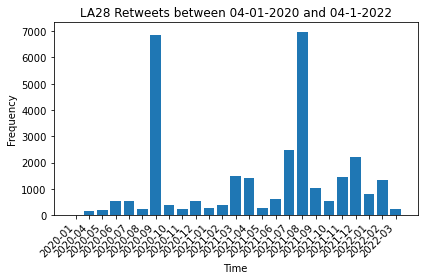

In [61]:
#plotting bar graph of num of original #la28 tweets over time
#import matplotlib.pyplot as plt

data = clean_time
dates = list(data.keys())
tweet_count = list(data.values())

x = np.arange(len(dates))  # the label locations
margin = 0.09
width = (1. - 2. * margin) / 5
fig, ax = plt.subplots()

plt.bar(range(len(data)), tweet_count, tick_label=dates)

ax.set_ylabel('Frequency')
ax.set_xlabel('Time')
ax.set_title('LA28 Retweets between 04-01-2020 and 04-1-2022')
ax.set_xticks(x)
ax.set_xticklabels(dates, rotation=45, ha="right")
#ax.legend()
fig.tight_layout()
plt.savefig("official_retweets_only_2020-2022.png")
plt.show()